## Description
This notebook processes all datasets containing German keywords (dataset_keyword_DE). It first applies a DBSCAN clustering algorithm using embeddings generated by a BERT-based model. In a second iteration, common or generic keywords are filtered out, and the clustering is performed again on the cleaned data.

The code was developed with support from ChatGPT-4.

In [36]:
import re
import ast
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import download
from sentence_transformers import SentenceTransformer
from collections import Counter, defaultdict
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Download German stopwords (only necessary once)
download('stopwords')
german_stopwords = set(stopwords.words('german'))

# Load SBERT Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the dataset
inputdata_file = 'data/merged_dataset_metadata_labelled.csv'
df = pd.read_csv(inputdata_file, low_memory=False)

# Filter: only rows labeled 'T' and with iteration_index == 1 (ensures DE description and title exist)
df = df[(df['mobilitydata_labelled'] == 'T') & (df['iteration_index'].isin([1]))]

# Identify rows with non-empty dataset_keyword_DE
valid_keywords = df['dataset_keyword_DE'].notnull() & df['dataset_keyword_DE'].str.strip().ne("")

# Assign cluster = -2 for rows without valid keywords
df.loc[~valid_keywords, 'cluster'] = -2

# Tokenization function: remove stopwords and short words (≤ 2 chars)
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [token for token in tokens if token not in german_stopwords and len(token) > 2]

# Apply tokenization to valid rows only
texts = df.loc[df['cluster'] != -2, 'dataset_keyword_DE'].apply(tokenize).tolist()

print(f"{(df['cluster'] != -2).sum()} cleaned and tokenized texts with label 'T' found.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3132 cleaned and tokenized texts with label 'T' found.


In [37]:
# Define keywords to remove
keywords_to_remove = [
    'verkehr', 
    'opendata', 
    'geoportal', 
    'opendata.swiss', 
    'bgdi bundesgeodaten-infrastruktur', 
    'bgdi-bundesgeodaten-infrastruktur', 
    'geodaten',
    'geobasisdaten',
    'geodatenmodell'
]

# Convert string representations of lists into actual Python lists
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Function to remove unwanted keywords from a list
def remove_keywords(keyword_list):
    if isinstance(keyword_list, list):
        return [kw for kw in keyword_list if kw.lower() not in keywords_to_remove]
    return keyword_list

# Apply the keyword removal function
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(remove_keywords)

# Identify empty or invalid keyword lists after filtering
empty_keyword_mask = (
    df['dataset_keyword_DE'].isna()
    | df['dataset_keyword_DE'].apply(lambda x: isinstance(x, str) and x.strip() == "")
    | df['dataset_keyword_DE'].apply(lambda x: isinstance(x, list) and len(x) == 0)
)

# Mark these rows with cluster = -2
df.loc[empty_keyword_mask, 'cluster'] = -2

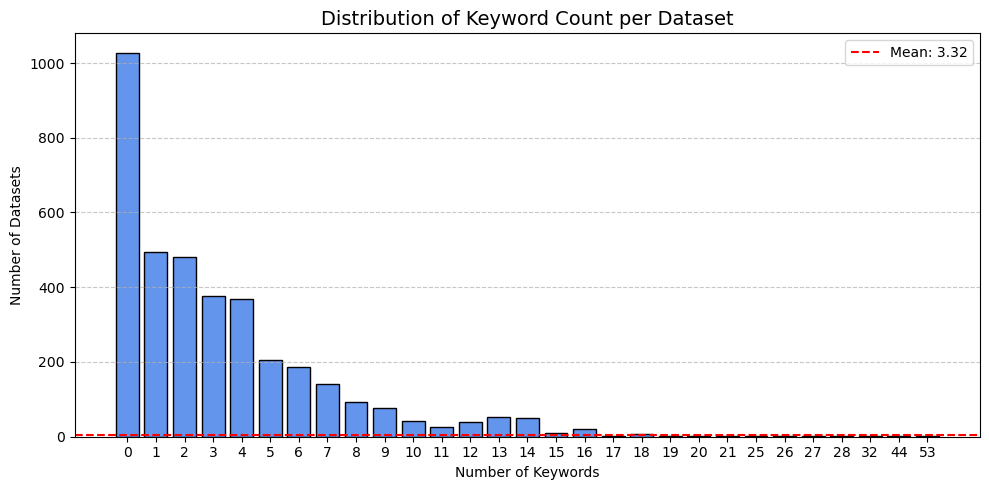

In [38]:
# Calculate the number of keywords per entry (only for valid lists)
df['keyword_count'] = df['dataset_keyword_DE'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Plot histogram / bar chart of keyword counts
plt.figure(figsize=(10, 5))
counts = df['keyword_count'].value_counts().sort_index()
bars = plt.bar(counts.index.astype(str), counts.values, color='cornflowerblue', edgecolor='black')

# Calculate mean keyword count
mean_keywords = df['keyword_count'].mean()

# Draw mean line
plt.axhline(y=mean_keywords, color='red', linestyle='--', label=f'Mean: {mean_keywords:.2f}')

# Layout and labels
plt.title("Distribution of Keyword Count per Dataset", fontsize=14)
plt.xlabel("Number of Keywords")
plt.ylabel("Number of Datasets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Use only valid rows for embedding and clustering (cluster != -2)
df_valid = df[df['cluster'] != -2].copy()

# Extract token lists for embedding
cleaned_texts = df_valid['dataset_keyword_DE'].tolist()

print(f"{len(cleaned_texts)} cleaned and tokenized texts with label 'T' found.")

2693 cleaned and tokenized texts with label 'T' found.


In [40]:
# Convert keyword lists into space-separated strings
documents = [" ".join(tokens) for tokens in cleaned_texts]

# generate embeddings
embeddings = model.encode(documents, show_progress_bar=True)

# reduce dimensions with UMAP before clustering
reducer = umap.UMAP(n_components=50, random_state=1)
reduced_embeddings = reducer.fit_transform(embeddings)

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Automatisch erkannter eps-Wert: 0.4554


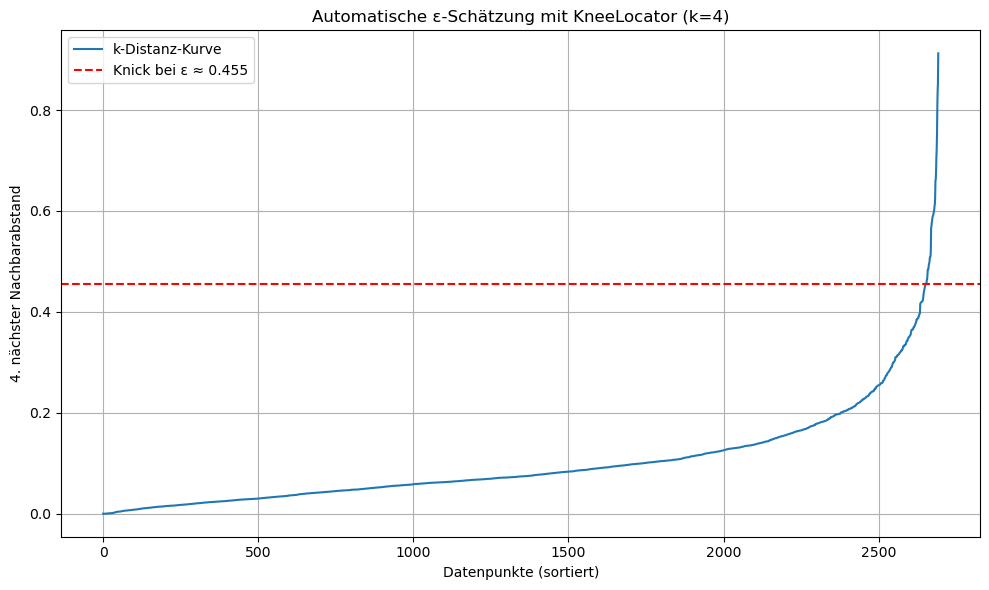

In [41]:
# Parameter: min_samples - 1 = k
k = 4 
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(reduced_embeddings)

# Compute distances to the k-nearest neighbors (only the k-th distance per point is used)
distances, indices = neigh.kneighbors(reduced_embeddings)
k_distances = np.sort(distances[:, -1]) # Sorted k-th nearest neighbor distances

# Automatic knee detection using KneeLocator
kneedle = KneeLocator(x=range(len(k_distances)), y=k_distances, curve='convex', direction='increasing')

# Suggested eps value
optimal_eps = kneedle.knee_y

print(f"Automatisch erkannter eps-Wert: {optimal_eps:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_distances, label='k-Distanz-Kurve')
if optimal_eps is not None:
    plt.axhline(optimal_eps, color='red', linestyle='--', label=f'Knick bei ε ≈ {optimal_eps:.3f}')
plt.title(f"Automatische ε-Schätzung mit KneeLocator (k={k})")
plt.xlabel("Datenpunkte (sortiert)")
plt.ylabel(f"{k}. nächster Nachbarabstand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# DBSCAN clustering on reduced embeddings
clustering = DBSCAN(eps=optimal_eps, min_samples=k)
labels = clustering.fit_predict(reduced_embeddings)

df.loc[df['cluster'] != -2, 'cluster'] = labels

# Reduce dimensionality to 2D using UMAP for visualization
reducer = umap.UMAP(n_components=2, random_state=1)
embedding_2d = reducer.fit_transform(embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': labels,
    'text': documents
})

c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\haabs\AppData\Local\Temp\ipykernel_39692\2934963010.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_clusters))


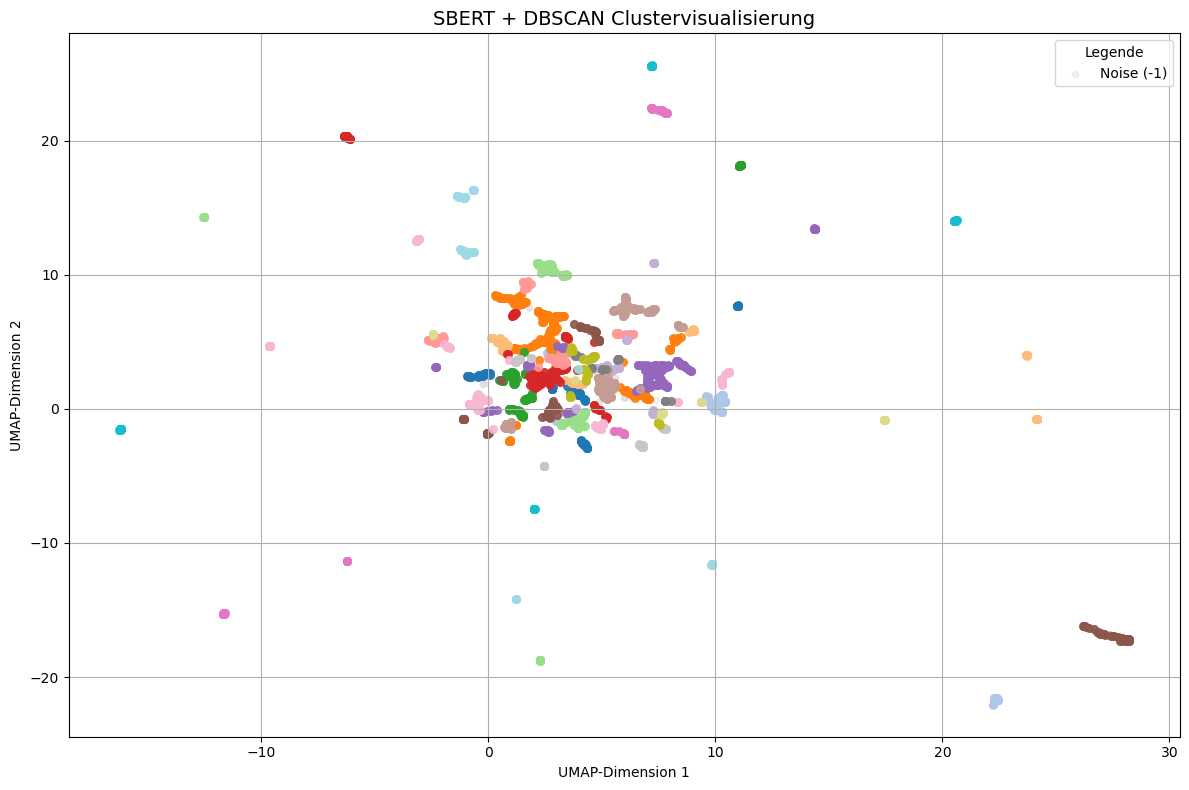

In [43]:
plt.figure(figsize=(12, 8))

# Get unique cluster labels (excluding noise cluster -1)
unique_clusters = sorted(set(labels) - {-1})
color_map = plt.cm.get_cmap('tab20', len(unique_clusters))

# Plot noise points (cluster == -1) in light grey
noise_mask = labels == -1
plt.scatter(
    embedding_2d[noise_mask, 0],
    embedding_2d[noise_mask, 1],
    c='lightgrey',
    alpha=0.3,
    s=20,
    label='Noise (-1)'
)

# Plot each valid cluster with a unique color, without legend entry
for idx, cluster_id in enumerate(unique_clusters):
    cluster_mask = labels == cluster_id
    plt.scatter(
        embedding_2d[cluster_mask, 0],
        embedding_2d[cluster_mask, 1],
        c=[color_map(idx)],
        alpha=0.9,
        s=30,
        label=None  # omit cluster ID from legend
    )

# Plot-Layout
plt.title("SBERT + DBSCAN Clustervisualisierung", fontsize=14)
plt.xlabel("UMAP-Dimension 1")
plt.ylabel("UMAP-Dimension 2")
plt.grid(True)
plt.legend(title="Legende", loc='best', fontsize=10)
plt.tight_layout()
plt.show()


C:\Users\haabs\AppData\Local\Temp\ipykernel_39692\1940697353.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_plot, df_excluded], ignore_index=True)


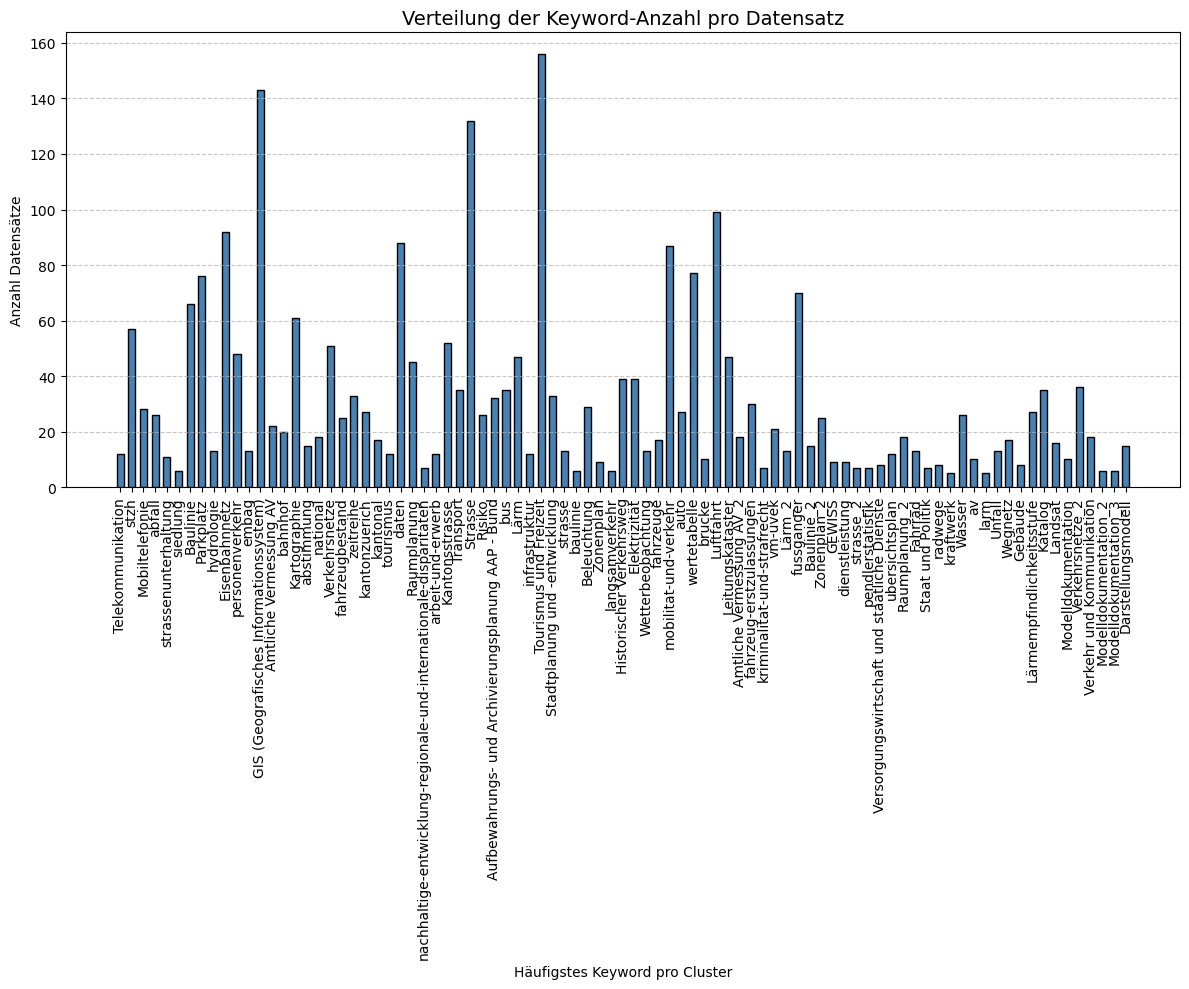

In [44]:
# Assign tokenized keyword lists to df_plot
df_plot['tokens'] = cleaned_texts

# Extract all rows from the original df with cluster == -1 or -2
df_excluded = df[df['cluster'].isin([-1, -2])].copy()

# Add missing columns (for consistency with df_plot)
df_excluded['x'] = np.nan
df_excluded['y'] = np.nan
df_excluded['text'] = None
df_excluded['tokens'] = None

# Keep only relevant columns (intersection of df_plot and df_excluded)
df_excluded = df_excluded[df_plot.columns.intersection(df_excluded.columns)]

# Combine clustered data (df_plot) with noise and empty keyword entries (df_excluded)
df_combined = pd.concat([df_plot, df_excluded], ignore_index=True)

# Remove noise points (cluster == -1) for cluster-specific analysis
df_plot = df_plot[df_plot['cluster'] != -1]

# Determine the most frequent word (token) in each cluster
cluster_top_words = {}
for cluster_id in sorted(df_plot['cluster'].unique()):
    cluster_tokens = df_plot[df_plot['cluster'] == cluster_id]['tokens'].explode()
    if not cluster_tokens.empty:
        word_counts = Counter(cluster_tokens)
        most_common_word, _ = word_counts.most_common(1)[0]
        cluster_top_words[cluster_id] = most_common_word
    else:
        cluster_top_words[cluster_id] = "–"

# Count the number of entries in each cluster
cluster_counts = df_plot['cluster'].value_counts().sort_index()
df_stats = cluster_counts.reset_index()
df_stats.columns = ['cluster', 'Num_Texts']

# Map the top word to each cluster
df_stats['Top_Word'] = df_stats['cluster'].map(cluster_top_words)

# Create unique labels (e.g. "verkehr", "verkehr_2" if word occurs multiple times)
word_counter = defaultdict(int)
unique_labels = []

for word in df_stats['Top_Word']:
    word_counter[word] += 1
    label = word if word_counter[word] == 1 else f"{word}_{word_counter[word]}"
    unique_labels.append(label)

df_stats['Label'] = unique_labels

# Plot: number of entries per cluster, labeled with top word
plt.figure(figsize=(12, 10))
x_positions = range(len(df_stats))
bars = plt.bar(
    x_positions,
    df_stats['Num_Texts'],
    color='steelblue',
    edgecolor='black',
    width=0.6
)

plt.xticks(ticks=x_positions, labels=df_stats['Label'], rotation=90)
plt.title("Verteilung der Keyword-Anzahl pro Datensatz", fontsize=14)
plt.xlabel("Häufigstes Keyword pro Cluster")
plt.ylabel("Anzahl Datensätze")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
# Cluster distribution directly from df
cluster_distribution = df['cluster'].value_counts().sort_index()

# Count noise entries (cluster == -1)
num_noise = cluster_distribution.get(-1, 0)

# Count entries with empty or invalid keywords (cluster == -2)
num_empty = cluster_distribution.get(-2, 0)

# Count of entries assigned to actual clusters (cluster >= 0)
num_clustered = cluster_distribution.loc[cluster_distribution.index >= 0].sum()

# Count of entries with valid keywords (cluster != -2)
num_total_valid = (df['cluster'] != -2).sum()

# Select entries assigned to true clusters (cluster >= 0)
df_true_clusters = df[df['cluster'] >= 0].copy()
true_cluster_counts = df_true_clusters['cluster'].value_counts().sort_index()

# Output statistics
print("Entries per true cluster:")
print(true_cluster_counts)
print(f"\nNumber of true clusters: {true_cluster_counts.count()}")
print(f"Number of noise entries (cluster -1): {num_noise}")
print(f"Number of entries with empty keywords (cluster -2): {num_empty}")
print(f"Total number of entries with valid keywords: {num_total_valid}")
print(f"Total clustered (excluding noise): {num_clustered}")

Entries per true cluster:
cluster
0.0     12
1.0     57
2.0     28
3.0     26
4.0     11
        ..
82.0    36
83.0    18
84.0     6
85.0     6
86.0    15
Name: count, Length: 87, dtype: int64

Number of true clusters: 87
Number of noise entries (cluster -1): 21
Number of entries with empty keywords (cluster -2): 1028
Total number of entries with valid keywords: 2693
Total clustered (excluding noise): 2672


In [46]:
df.to_csv("data/01_DBSCAN_cluster.csv", index=False, encoding='utf-8')